In [1]:
import numpy as np
import tensorflow as tf
from node.core import get_node_function
from node.fix_grid import RKSolver
from node.utils.initializers import GlorotUniform
from node.utils.train import print_status_bar
from node.utils.trajectory import tracer


# for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


@tf.function
def flatten(x):
    """
    Args:
        x: tf.Tensor
            In the shape `[batch_size, ...]`.

    Returns: tf.Tensor
        In the shape `[batch_size, None]`.
    """
    batch_size, *_ = x.get_shape().as_list()
    return tf.reshape(x, [batch_size, -1])


def get_energy(network, correlation=None):
    r"""
    Args:
        network: Callable[[tf.Tensor], tf.Tensor]
        correlation: Optional[tf.Tensor]
            The correlation matrix $W_{ij}$

    Returns: Callable[[tf.Tensor], tf.Tensor]
        Energy per sample.
    """

    @tf.function
    def energy(x):
        z1 = flatten(network(x))
        if correlation is None:
            z2 = z1
        else:
            z2 = tf.matmul(z1, correlation, transpose_a=True)
        return tf.reduce_sum(z1 * z2, axis=1)

    return energy


def get_pvf(network):
    """
    Args:
        network: Callable[[tf.Tensor], tf.Tensor]

    Returns: PhaseVectorField
    """

    @tf.function
    def pvf(t, x):
        with tf.GradientTape() as g:
            g.watch(x)
            z = network(x)
        return -g.gradient(z, x, z)

    return pvf


class MyLayer(tf.keras.layers.Layer):

    def __init__(self, units, dt, num_grids, **kwargs):
        super().__init__(**kwargs)
        self.dt = dt
        self.num_grids = num_grids

        t0 = tf.constant(0.)
        self.tN = t0 + num_grids * dt

        self._model = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='relu',
                                  kernel_initializer=GlorotUniform(1e-1)),
            tf.keras.layers.Dense(units, activation='relu',
                                  kernel_initializer=GlorotUniform(1e-1)),
        ])
        self._model.build([None, units])

        self._pvf = get_pvf(self._model)
        self._node_fn = get_node_function(RKSolver(self.dt),
                                          tf.constant(0.),
                                          self._pvf)

    def call(self, x):
        y = self._node_fn(self.tN, x)
        return y


def process(X, y):
    X = X / 255.
    X = tf.reshape(X, [-1, 28 * 28])
    y = tf.one_hot(y, 10)
    return tf.cast(X, tf.float32), tf.cast(y, tf.float32)


mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = process(x_train, y_train)
x_test, y_test = process(x_test, y_test)

model = tf.keras.Sequential([
    tf.keras.layers.Input([28 * 28]),
    tf.keras.layers.Dense(64),
    MyLayer(64, dt=1e-1, num_grids=5),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 24s 398us/sample - loss: 0.4606 - accuracy: 0.8645
Epoch 2/10
60000/60000 [==============================] - 17s 289us/sample - loss: 0.3394 - accuracy: 0.9016
Epoch 3/10
60000/60000 [==============================] - 17s 291us/sample - loss: 0.2971 - accuracy: 0.9141
Epoch 4/10
60000/60000 [==============================] - 18s 293us/sample - loss: 0.2840 - accuracy: 0.9167
Epoch 5/10
60000/60000 [==============================] - 18s 308us/sample - loss: 0.2621 - accuracy: 0.9236
Epoch 6/10
60000/60000 [==============================] - 19s 323us/sample - loss: 0.2486 - accuracy: 0.9277
Epoch 7/10
60000/60000 [==============================] - 19s 322us/sample - loss: 0.2425 - accuracy: 0.9307
Epoch 8/10
60000/60000 [==============================] - 20s 332us/sample - loss: 0.2384 - accuracy: 0.9315
Epoch 9/10
60000/60000 [==============================] - 20s 338us/sample - loss: 0.2794 - accuracy: 0.9

In [2]:
model.layers

In [3]:
my_layer_id = 1
my_layer = model.layers[my_layer_id]
trace = tracer(RKSolver(0.1), my_layer._pvf)
energy_fn = get_energy(my_layer._model)

truncated_model = tf.keras.Sequential(model.layers[:my_layer_id])
hidden = truncated_model(x_train[:100])
labels = y_train[:100]
trajectory = trace(t0=tf.constant(0.),
                   t1=tf.constant(5.),
                   dt=tf.constant(0.1),
                   x=hidden)


def energy_along_trajectory(trajectory):
    shape = trajectory.get_shape().as_list()
    batch_size, trajectory_size, *phase_dims = shape
    phase_points = tf.reshape(trajectory, [-1, *phase_dims])
    e = energy_fn(phase_points)
    return tf.reshape(e, [batch_size, trajectory_size])


energy = energy_along_trajectory(trajectory)

In [4]:
from node.utils.trajectory import visualize_trajectory
from IPython.display import HTML

In [5]:
labels_ = np.argmax(labels.numpy(), -1)
print(list(enumerate(labels_)))

[(0, 5), (1, 0), (2, 4), (3, 1), (4, 9), (5, 2), (6, 1), (7, 3), (8, 1), (9, 4), (10, 3), (11, 5), (12, 3), (13, 6), (14, 1), (15, 7), (16, 2), (17, 8), (18, 6), (19, 9), (20, 4), (21, 0), (22, 9), (23, 1), (24, 1), (25, 2), (26, 4), (27, 3), (28, 2), (29, 7), (30, 3), (31, 8), (32, 6), (33, 9), (34, 0), (35, 5), (36, 6), (37, 0), (38, 7), (39, 6), (40, 1), (41, 8), (42, 7), (43, 9), (44, 3), (45, 9), (46, 8), (47, 5), (48, 9), (49, 3), (50, 3), (51, 0), (52, 7), (53, 4), (54, 9), (55, 8), (56, 0), (57, 9), (58, 4), (59, 1), (60, 4), (61, 4), (62, 6), (63, 0), (64, 4), (65, 5), (66, 6), (67, 1), (68, 0), (69, 0), (70, 1), (71, 7), (72, 1), (73, 6), (74, 3), (75, 0), (76, 2), (77, 1), (78, 1), (79, 7), (80, 9), (81, 0), (82, 2), (83, 6), (84, 7), (85, 8), (86, 3), (87, 9), (88, 0), (89, 4), (90, 6), (91, 7), (92, 4), (93, 6), (94, 8), (95, 0), (96, 7), (97, 8), (98, 3), (99, 1)]


In [6]:
def visualize(trajectory, label):
    print(f'label: {label}')
    anim = visualize_trajectory(trajectory.reshape([-1, 8, 8]))
    return HTML(anim.to_html5_video())

label: 5


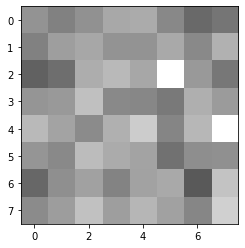

In [7]:
i = 0
visualize(trajectory.numpy()[i], labels_[i])

label: 5


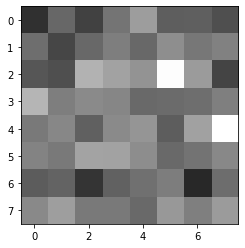

In [8]:
i = 11
visualize(trajectory.numpy()[i], labels_[i])

label: 5


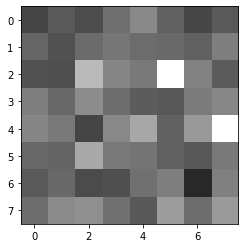

In [9]:
i = 35
visualize(trajectory.numpy()[i], labels_[i])

label: 6


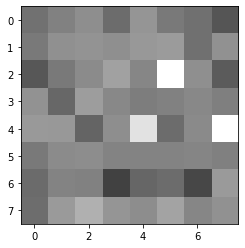

In [10]:
i = 36
visualize(trajectory.numpy()[i], labels_[i])

label: 0


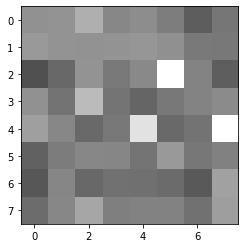

In [11]:
i = 37
visualize(trajectory.numpy()[i], labels_[i])